# Rozwiązywanie stochastycznych równań różniczkowych z CUDA

Równania stochastyczne są niezwykle pożytecznym narzędziem w modelowaniu zarówno procesów fizycznych, biolgicznych czy chemicznych a nawet ekonomicznych (wycena instrumentów pochodnych).

Klasycznym przykładem problemu z jakim się spotykami przy numerycznym rozwiązywaniu równań stochastycznych jest konieczność uśrednienia po wielu niezależnych od siebie realizacjach procesu losowego. Mówiąc wprost musimy rozwiązać numerycznie wiele razy to samo równanie różniczkowe, za każdym razem zmieniając "seed" generatora liczb losowych. Jest to idealny problem dla urządzenia GPU, gdzie generacja niezależnych trajektorii wielu kopii tego samego układu jest w stanie wykorzystać maksymalnie jego możliwości obliczeniowe.

Poniżej przedstawiamy implementację algorytmu, wg. pierwszego przykładu z pracy: http://arxiv.org/abs/0903.3852 

Róźnicą będzie skorzystanie z pycuda, zamiast C. Co ciekawe, taka modyfikacja jest w stanie przyśpieszyć kernel obliczniowe o ok 25%. Spowodowane jest to zastosowaniem metoprogramowania. Pewne parametry, które nie zmieniają się podczas wykonywania kodu są "klejane" do źródła jako konkrente wartości liczbowe, co ułatwia kompilatorowi `nvcc` optymalizacje.

W tym przykładzie wykorzystamy własny generator liczb losowych i transformację Boxa-Mullera (zamiast np. curand). 

Przykład ten może być z łatwością zmodyfikowany na dowolny układ SDE, dlatego można do traktować jako szablon dla własnych zagadnień.



## Struktura programu

### Szablony 

Niezwykle pomocne w programowaniu w pycuda jest zastosowanie metaprogramowania - to jest - piszemy program piszący nasz kernel. Tutaj mamy najprostszy wariant, po prostu pewne parametry równań, wpisujemy automatycznie do tekstu jądra. W pythonie jest przydatne formatowanie "stringów" np.:




In [1]:
print '%(language)04d a nawiasy {} ' % {"language": 1234, "number": 2}

1234 a nawiasy {} 


lub:

In [2]:
print '{zmienna} a nawiasy: {{}}'.format( **{"zmienna": 123} )

123 a nawiasy: {}


W pewnych bardziej zaawansowanych przypadkach, można zastosować system szablonów np. mako templates (w projekcie http://sailfish.us.edu.pl). 


### Struktura kernela

Jądro:

    __global__ void SDE(float *cx,float *cv,unsigned int *rng_state, float ct)

jest funkcją CUDA typu `__global__`, jako parametry przyjmuje tablice `cx` i `cv`, będące zmiennymi stanu układu dwóch równań różniczkowch:

$$ \dot x = v$$
$$ \dot v = -2\pi \cos(2.0\pi x) + A \cos(\omega t) + F - \gamma v$$

Ponadto w wywołaniu przekazujemy czas (przez wartość) oraz wskaźnik do stanu generatora liczb losowych na GPU.

Funkje dostępne dla jądra z GPU to:

generator liczb losowych o rozkładzie jednostajnym:

     __device__ float rng_uni(unsigned int *state)

transformacja Boxa-Mullera:

     __device__ void bm_trans(float& u1, float& u2)

i wreszczcie funkcja obliczająca prawe strony układu równań:

     __device__ inline void diffEq(float &nx, float &nv, float x, float v, float t)


Zauważmy, że dla poprawienia wydajności, każde wywołanie kernela, powoduje wielokrotne (określone przez parametr `spp`) wykonanie pętli iteracyjnej. 




In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pycuda.gpuarray as gpuarray

from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda


cuda.init()
device = cuda.Device(0)
ctx = device.make_context()
print device.name(), device.compute_capability(),device.total_memory()/1024.**3,"GB"


blocks = 2**11
block_size = 2**8
N = blocks*block_size

omega = 4.9
spp = 100
dt = 2.0*np.pi/omega/spp
pars = {'samples':spp,'N':N,'dt':dt,'gam':0.9,'d0':0.001,'omega':omega,'force':0.1,'amp':4.2}

rng_src = """
#define PI 3.14159265358979f
/*
 * Return a uniformly distributed random number from the
 * [0;1] range.
 */
__device__ float rng_uni(unsigned int *state)
{
	unsigned int x = *state;

	x = x ^ (x >> 13);
	x = x ^ (x << 17);
	x = x ^ (x >> 5);

	*state = x;

	return x / 4294967296.0f;
}
/*
 * Generate two normal variates given two uniform variates.
 */
__device__ void bm_trans(float& u1, float& u2)
{
	float r = sqrtf(-2.0f * logf(u1));
	float phi = 2.0f * PI * u2;
	u1 = r * cosf(phi);
	u2 = r * sinf(phi);
}

"""

src = """
  __device__ inline void diffEq(float &nx, float &nv, float x, float v, float t)
{{
	nx = v;
	nv = -2.0f * PI * cosf(2.0f * PI * x) + {amp}f * cosf({omega}f * t) + {force}f - {gam}f * v;
}}

__global__ void SDE(float *cx,float *cv,unsigned int *rng_state, float ct)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;
      float n1, n2; 	
      unsigned int lrng_state;
      float xim, vim, xt1, vt1, xt2, vt2,t,x,v;
      lrng_state = rng_state[idx]; 
      t = ct;
      x = cx[idx];
	  v = cv[idx]; 
    
      for (int i=1;i<={samples};i++)  {{
      	n1 = rng_uni(&lrng_state);
		n2 = rng_uni(&lrng_state);
		bm_trans(n1, n2);
	diffEq(xt1, vt1, x, v, t);
		xim = x + xt1 * {dt}f;
		vim = v + vt1 * {dt}f + sqrtf({dt}f * {gam}f * {d0}f * 2.0f) * n1;
		t = ct + i * {dt}f;
	diffEq(xt2, vt2, xim, vim, t);
		x += 0.5f * {dt}f * (xt1 + xt2);
		v += 0.5f * {dt}f * (vt1 + vt2) + sqrtf(2.0f * {dt}f * {gam}f * {d0}f) * n2;
      }}
       cx[idx] = x;
	   cv[idx] = v;

	   rng_state[idx] = lrng_state;;
       
    }}
    """.format(**pars)

mod = SourceModule(rng_src + src,options=["--use_fast_math"])
SDE = mod.get_function("SDE")

print "kernel ready for ",block_size,"N =",N,N/1e6

Tesla K40m (3, 5) 11.9998168945 GB
kernel ready for  256 N = 524288 0.524288


In [5]:
print spp,N

100 524288


Mając gotowe jądro, można wykonac testowe uruchomienie:

In [6]:
import time

x  = np.zeros(N,dtype=np.float32)
v  = np.ones(N,dtype=np.float32)
rng_state = np.array(np.random.randint(1,2147483648,size=N),dtype=np.uint32)

x_g = gpuarray.to_gpu(x)
v_g = gpuarray.to_gpu(v)
rng_state_g = gpuarray.to_gpu(rng_state)

start = time.time()
for i in range(0,200000,spp):
    t = i * 2.0 * np.pi /omega /spp;
    SDE(x_g, v_g, rng_state_g, np.float32(t), block=(block_size,1,1), grid=(blocks,1))

ctx.synchronize()
elapsed = (time.time() - start)
x=x_g.get()
print elapsed,N/1e6, 200000*N/elapsed/1024.**3,"Giter/sek"

3.46368002892 0.524288 28.1943624078 Giter/sek


Wynikiem działania programu jest $N$ liczb określających końcowe położenie cząstki. Możemy zwizualizować je wykorzystując np. hostogram:

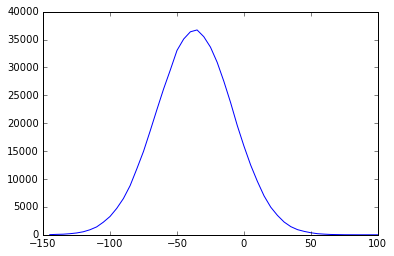

In [7]:
h = np.histogram(x,bins=50,range=(-150, 100) ) 
plt.plot(h[1][1:],h[0])

### Dane referencyjne dla walidacji

W tablicy `hist_ref` znajdują się dane referencyjne dla celów walidacji. Możemy sprawdzić czy program działa tak jak ten w pracy referencyjnej:

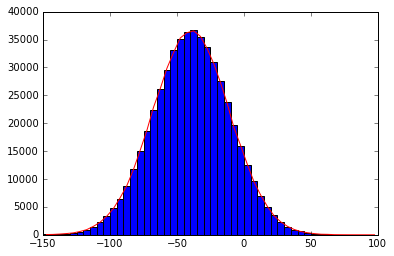

In [8]:
hist_ref = (np.array([   46,    72,   134,   224,   341,   588,   917,  1504,  2235,\
        3319,  4692,  6620,  8788, 11700, 15139, 18702, 22881, 26195,\
       29852, 32700, 35289, 36232, 36541, 35561, 33386, 30638, 27267,\
       23533, 19229, 16002, 12646,  9501,  7111,  5079,  3405,  2313,\
        1515,   958,   573,   370,   213,   103,    81,    28,    15,\
           7,     3,     2,     0,     0]),\
 np.array([-150., -145., -140., -135., -130., -125., -120., -115., -110.,\
       -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,  -70.,  -65.,\
        -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,  -25.,  -20.,\
        -15.,  -10.,   -5.,    0.,    5.,   10.,   15.,   20.,   25.,\
         30.,   35.,   40.,   45.,   50.,   55.,   60.,   65.,   70.,\
         75.,   80.,   85.,   90.,   95.,  100.]) )



plt.hist(x,bins=50,range=(-150, 100) ) 
plt.plot((hist_ref[1][1:]+hist_ref[1][:-1])/2.0,hist_ref[0],'r')

## Zadania

### ElementwiseKernel

Napisać program całkujący równanie stochastyczne, wykorzystujące `ElementwiseKernel`

In [9]:
from pycuda.elementwise import ElementwiseKernel
SDE2 = ElementwiseKernel(
        "float *x,unsigned int  *rng_state",
        "x[i] = x[i]+0.01*f(x[i]) + sqrtf(0.01*0.1)*rng_uni( &(rng_state[i]) ) ",
        "SDE",
        preamble="""
        __device__ float f(float x)
        { 
          return sin(x)+0.1;
        }
        """+rng_src)


### Wydajność

Zbadać jak zmienia się wydajność programu w zależności od wielkości bloku

### Równanie dyfuzji 2d

Napisać program rozwiązujący równanie dyfuzji 2d metodą symulacji odpowiedniego SDE.